In [35]:
%load_ext autoreload
%autoreload 2

from project_root import PROJECT_ROOT

import torchvision as tv
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import enlighten
from pathlib import Path

pbar_manager = enlighten.get_manager()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
torch.autograd.set_grad_enabled(False)

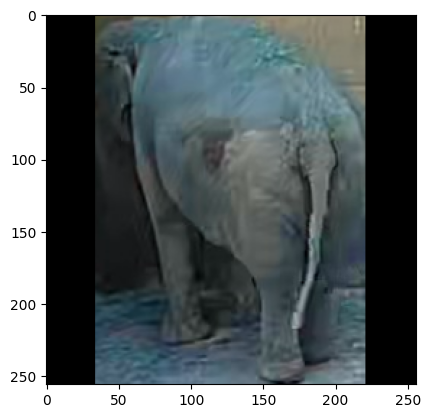

In [37]:
########################
# Test patch extraction
from scripts.datasets.segmentation_utils import bbox_from_mask
from scripts.datasets.identity_from_detection_ds import crop_bbox

data_root = Path("/home/dherrera/data/elephants")
src_root = data_root / "training_data"
files = list(src_root.glob("**/*_img.jpg"))
img_file = files[0]
seg_file = Path(str(img_file).replace("_img.jpg", "_seg.png"))

# Load
im_color: np.ndarray = cv2.imread(img_file)
im_segmentation: np.ndarray = cv2.imread(seg_file, cv2.IMREAD_GRAYSCALE)

greys = [int(x) for x in np.unique(im_segmentation) if x != 0]
grey = greys[0]

mask = im_segmentation == grey
bbox = bbox_from_mask(mask)
crop = crop_bbox(im_color, bbox)
plt.imshow(crop)

In [38]:
########################
# Test trained model

USE_JIT = True
path = "/home/dherrera/git/zoo_vision/models/identity/dense121_c5_identity"
if USE_JIT:
    model = torch.jit.load(path + ".ptc")
    transforms = lambda x: x
else:
    model = tv.models.densenet121(num_classes=5)
    checkpoint = torch.load(path + ".pth", weights_only=False)
    model.load_state_dict(checkpoint["model"])

    transforms = tv.models.DenseNet121_Weights.IMAGENET1K_V1.transforms(antialias=True)
model.eval()
# model = tv.models.densenet121(tv.models.DenseNet121_Weights.IMAGENET1K_V1)
print(model)

RecursiveScriptModule(
  original_name=ModelWithTransforms
  (model): RecursiveScriptModule(
    original_name=DenseNet
    (features): RecursiveScriptModule(
      original_name=Sequential
      (conv0): RecursiveScriptModule(original_name=Conv2d)
      (norm0): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu0): RecursiveScriptModule(original_name=ReLU)
      (pool0): RecursiveScriptModule(original_name=MaxPool2d)
      (denseblock1): RecursiveScriptModule(
        original_name=_DenseBlock
        (denselayer1): RecursiveScriptModule(
          original_name=_DenseLayer
          (norm1): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu1): RecursiveScriptModule(original_name=ReLU)
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (norm2): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu2): RecursiveScriptModule(original_name=ReLU)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
        )
        (dense

In [39]:
if USE_JIT:
    transforms = lambda x: x
else:
    transforms = tv.models.DenseNet121_Weights.IMAGENET1K_V1.transforms(antialias=True)
print(transforms)

<function <lambda> at 0x7bbaa8eab240>


/home/dherrera/data/elephants/identity/dataset/train/01_Chandra/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_img.jpg


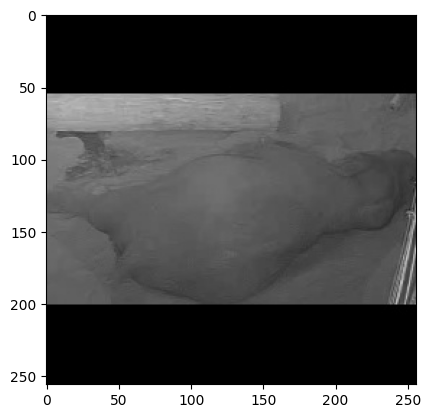

In [40]:
ds_path = Path("/home/dherrera/data/elephants/identity/dataset/train")
gt_class = "01_Chandra"

files = sorted(list((ds_path / gt_class).glob("*.jpg")))
# file = files[10]
file = Path(
    "/home/dherrera/data/elephants/identity/dataset/train/01_Chandra/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_img.jpg"
)
print(file)
im: np.ndarray = cv2.imread(file)
plt.imshow(im)

In [41]:
imt = transforms(torch.from_numpy(im.astype(np.float32) / 255).permute([2, 0, 1]))
imt = imt.unsqueeze(0)
result = model.forward(imt)
result

tensor([[ 1.5420, -1.0477,  1.0797, -1.8240,  0.2605]])

{'01_Chandra': 0, '02_Indi': 1, '03_Fahra': 2, '04_Panang': 3, '05_Thai': 4}


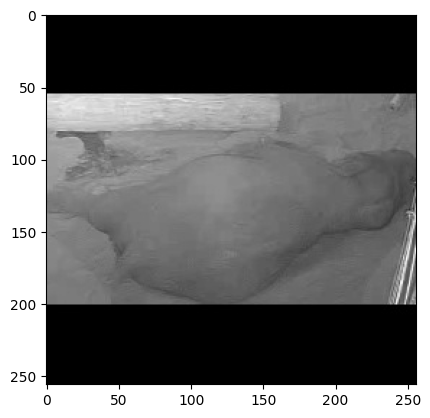

In [42]:
ds_transforms = tv.transforms.Compose([tv.transforms.PILToTensor(), transforms])
dataset_test = tv.datasets.ImageFolder(
    "/home/dherrera/data/elephants/identity/dataset/val", ds_transforms
)
print(dataset_test.class_to_idx)
ds_item, target = dataset_test[0]
if isinstance(ds_item, torch.Tensor):
    im = ds_item.permute([1, 2, 0]).numpy()
    im = im - np.mean(im)
    im = im - np.min(im)
    im = im / np.max(np.abs(im))
else:
    im = ds_item
plt.imshow(im)

In [43]:
inputs = torch.stack([ds_item, ds_item])
result = model.forward(inputs)
print(result)
print(target)
print(torch.argmax(result))

tensor([[ 1.5420, -1.0477,  1.0797, -1.8240,  0.2605],
        [ 1.5420, -1.0477,  1.0797, -1.8240,  0.2605]])
0
tensor(0)


In [44]:
from tqdm import tqdm

total = 0
correct = 0
for i in tqdm(range(0, len(dataset_test), 200)):
    ds_item, target = dataset_test[i]
    result = model.forward(ds_item[torch.newaxis, ...])
    y = torch.argmax(result).item()

    total += 1
    if y == target:
        correct += 1
accuracy = correct / total
print(f"Accuracy: {correct}/{total}={accuracy:%}")

100%|██████████| 48/48 [00:00<00:00, 54.06it/s]

Accuracy: 47/48=97.916667%


tensor([[ 1.3572, -0.1574,  0.9614, -2.1304, -0.0258]])

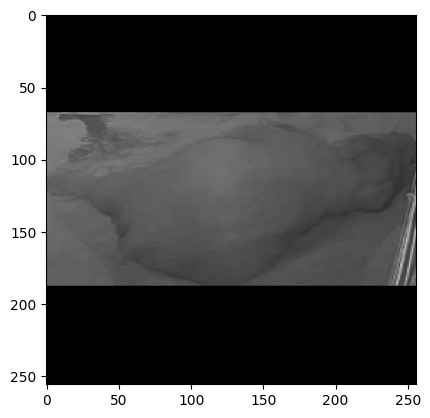

In [ ]:
im = cv2.imread(PROJECT_ROOT / "debug/region0.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
im_tensor = torch.from_numpy(im.astype(np.float32) / 255).permute([2, 0, 1])[None, ...]
model.forward(im_tensor)
# -0.1497  2.8303 -0.9907 -0.6594 -0.9898
#  1.3874 -0.1803  0.9937 -2.1601 -0.0361